# Real wave number

In [1]:
using Plots, SparseArrays, LinearAlgebra, Krylov, Revise
includet("nonuniformMultiGrid.jl")
includet("constructions2D.jl")
includet("grid_constructions1D.jl")
includet("grid_constructions2D.jl")
includet("linespacecs.jl")
includet("MG_preconditioner.jl")

In [2]:
n = 2^7
grid,m = linspacecs(0,1,n+1,pi/6)
f =zeros(length(grid),length(grid))
f[:,64] .= n
f = vec(f);
σ = -10000* ones(length(grid),length(grid))
σ[:, 126:130] .= -1000000
σ[union(106:110, 146:150), 126:130] .= -10000
sigmas = spdiagm(vec(σ))
H = helmholtz2D(grid,sigmas);

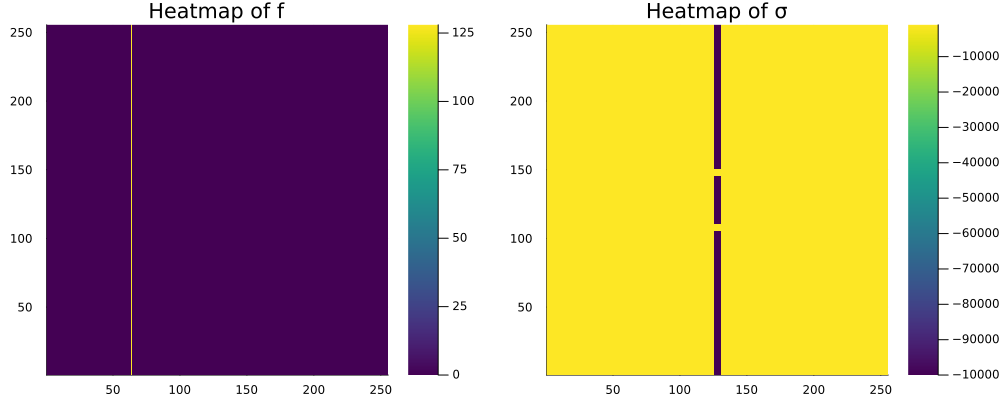

In [3]:
p1 = heatmap(reshape(f,length(grid),length(grid)), color=:viridis, title="Heatmap of f")
p2 = heatmap(reshape(σ,length(grid),length(grid)), color=:viridis, title="Heatmap of σ")

plot(p1, p2, layout = (1, 2), size = (1000, 400))

In [4]:
sol = H\f;

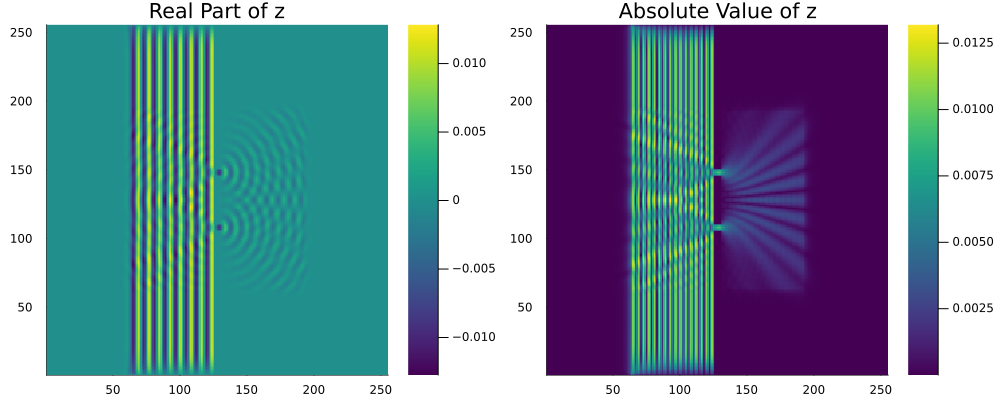

In [5]:
theme(:default)
z = reshape(sol, 2n-1, 2n-1)
p1 = heatmap(real(z), color=:viridis, title="Real Part of z")
p2 = heatmap(abs.(z), color=:viridis, title="Absolute Value of z")

plot(p1, p2, layout = (1, 2), size = (1000, 400))


In [6]:
u = zeros(length(f))
errors = Float64[]

for _ in 1:20
    u = nonUniformVcycle2D(
        grid=grid,
        A=H,
        f=f,
        u=u,
        nu1=1,
        nu2=1,
        recursion_depth=50)
    error = norm(sol - u)
    push!(errors, error)
end

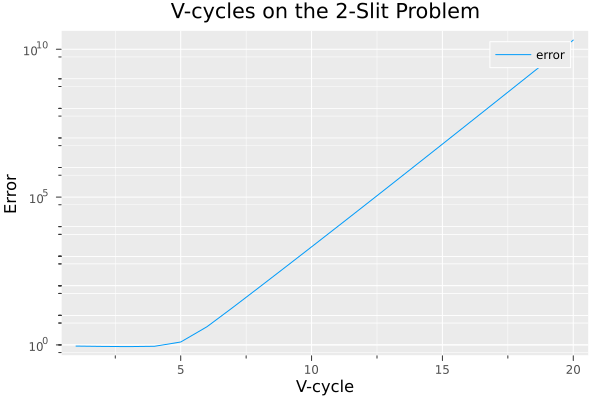

In [7]:
theme(:ggplot2)
p = plot(errors, title="V-cycles on the 2-Slit Problem", label="error", xlabel="V-cycle", ylabel="Error", yscale=:log10)

# Save the plot
savefig(p,"../plots/Convergence_of_V-cycles_on_the_2-Slit_Problem.pdf")
display(p)

Eigenvectors aren't easy to derive anymore, still need to find good explainer. Well we don't expect convergence without a wall and the wall acts like boundary conditions...

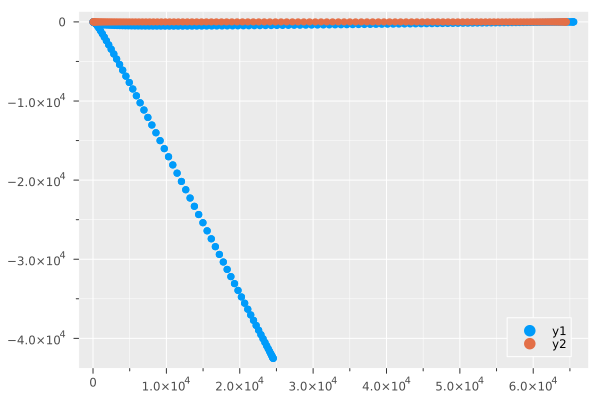

In [8]:
P = Poisson1D(grid)
Pr = Poisson1D(range(0,1,128))
eigenvalues = eigvals(Matrix(P))
scatter(real(eigenvalues),imag(eigenvalues))
eigenvalues = eigvals(Matrix(Pr))
scatter!(real(eigenvalues),imag(eigenvalues))

# Complex wave number

In [9]:
n = 2^7
grid,m = linspacecs(0,1,n+1,pi/6)
f =zeros(length(grid),length(grid))
f[:,64] .= n
f = vec(f);
complex_shift = (1+1*im)
σ = -10000 * ones(length(grid),length(grid))
σ[:, 126:130] .= -1000000
σ[union(106:110, 146:150), 126:130] .= -10000
σ_shifted = σ*complex_shift
sigmas_shifted = spdiagm(vec(σ_shifted))
H_shifted = helmholtz2D(grid,sigmas_shifted);

In [10]:
sol_shifted = H_shifted\f;

In [11]:
u_shifted = zeros(length(f))
errors_shifted = Float64[]

for i in 1:20
    u_shifted = nonUniformVcycle2D(
        grid=grid,
        A=H_shifted,
        f=f,
        u=u_shifted,
        nu1=1,
        nu2=1,
        recursion_depth=50)
    error = norm(sol_shifted - u_shifted)
    push!(errors_shifted, error)
end

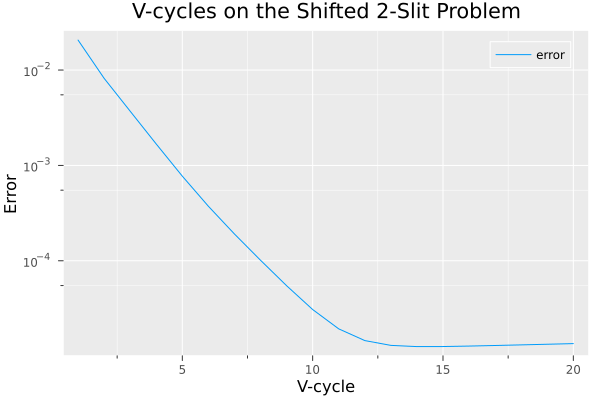

In [12]:
theme(:ggplot2)
p = plot(errors_shifted, title="V-cycles on the Shifted 2-Slit Problem", label="error", xlabel="V-cycle", ylabel="Error", yscale=:log10)

# Save the plot
savefig(p,"../plots/Vcycles_shifted2slit.pdf")
display(p)

# GMRES

In [13]:
n = 2^7
grid,m = linspacecs(0,1,n+1,pi/6)
f =zeros(length(grid),length(grid))
f[:,64] .= n
f = vec(f);
complex_shift = (1+im)
σ = -10000 * ones(length(grid),length(grid))
σ[:, 126:130] .= -1000000
σ[union(106:110, 146:150), 126:130] .= -10000
σ_shifted = σ*complex_shift
sigmas = spdiagm(vec(σ))
sigmas_shifted = spdiagm(vec(σ_shifted))
H = helmholtz2D(grid,sigmas);
H_shifted = helmholtz2D(grid,sigmas_shifted);

pre = nonuniform_preconditioner(; grid=grid, H=H_shifted,nu1=1,nu2=1);

In [14]:
S = Krylov.ktypeof(complex(float(f)))
global X = S[]  # Storage for GMRES iterates
gmres_callback(solver) = gmres_callbackX!(X,solver)

gmres_callback (generic function with 1 method)

In [15]:
X = S[]
presol, prestats = gmres(H, complex(float(f)), 
M=pre,
ldiv =false,
itmax = 150 ,
memory=201,
restart =true,
history=true,
callback =gmres_callback);
preres = [norm(H *x-f) for x in X];

In [16]:
X = S[]
nsol, nstats = gmres(H, complex(float(f)), 
M=I,
ldiv =false,
itmax = 150 ,
memory=201,
restart =true,
history=true,
callback =gmres_callback);
nres = [norm(H *x-f) for x in X];

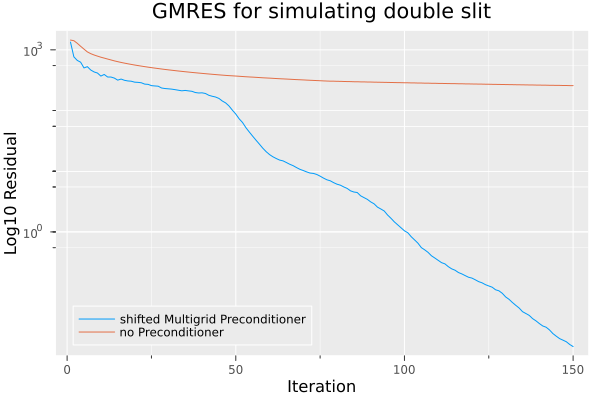

In [17]:
theme(:ggplot2)
p = plot(preres, yscale =:log10, label="shifted Multigrid Preconditioner",legend=:bottomleft)
plot!(p,nres, yscale =:log10, label="no Preconditioner")
title!(p,"GMRES for simulating double slit")
xlabel!(p,"Iteration")
ylabel!(p,"Log10 Residual")
savefig(p,"../plots/GMRES2slit.pdf")
display(p)